In [1]:
import os
import sys
import warnings
import time

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
warnings.simplefilter("ignore")

import tensorflow as tf
import numpy as np
from keras import mixed_precision
from keras.applications.vgg16 import VGG16
from keras.models import Model

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using device: {physical_devices[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU device found, using CPU")

print(mixed_precision.global_policy())
# mixed_precision.set_global_policy('mixed_float16')

from models import create_dataset_from_mapping_vgg

root_dir = os.path.abspath(os.path.join(".", ".."))

Using device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
<FloatDTypePolicy "float32">


In [2]:
train_dataset = create_dataset_from_mapping_vgg(mapping_file="train_mapping.csv").batch(256).prefetch(tf.data.experimental.AUTOTUNE)

2024-06-04 17:28:47.850445: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-04 17:28:47.850476: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-04 17:28:47.850485: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-04 17:28:47.850757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-04 17:28:47.850796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
model = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [4]:
X_train = model.predict(train_dataset.take(2))

2024-06-04 17:28:51.793218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [ ]:
X_train.shape

(320, 4096)

In [21]:
feat = feat.reshape(-1,4096)

In [22]:
feat.shape

(1000, 4096)

In [23]:
pca = PCA(n_components=0.99, random_state=42)
train_features = pca.fit_transform(feat)
# validation_features = pca.transform(val_images)
n_components = pca.n_components_
print(f"Number of components to retain 99% variance: {n_components}")

# Verify the shapes of the transformed features
print(f"Shape of train features after PCA: {train_features.shape}")
# print(f"Shape of validation features after PCA: {validation_features.shape}")

Number of components to retain 99% variance: 604
Shape of train features after PCA: (1000, 604)


In [24]:
x = train_features 

In [25]:
x.shape

(1000, 604)

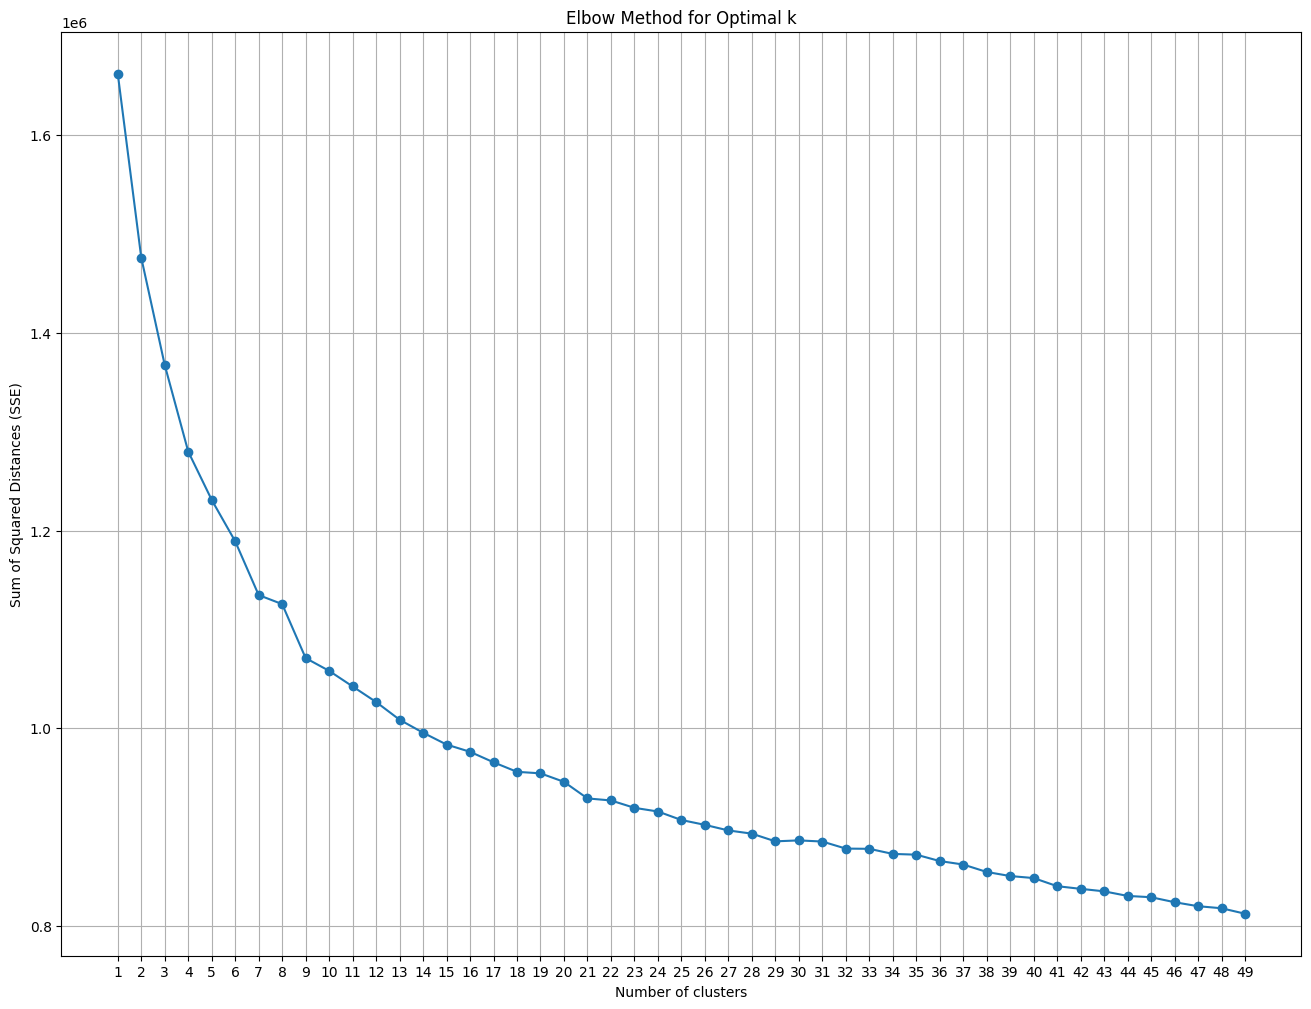

In [26]:
sse = []
list_k = list(range(1, 50))  # Range of cluster numbers to try

for k in list_k:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

# Plot SSE against the number of clusters
plt.figure(figsize=(16, 12))
plt.plot(list_k, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(list_k)
plt.grid(True)
plt.show()

Clustering: 100%|██████████| 18/18 [00:02<00:00,  7.74it/s]


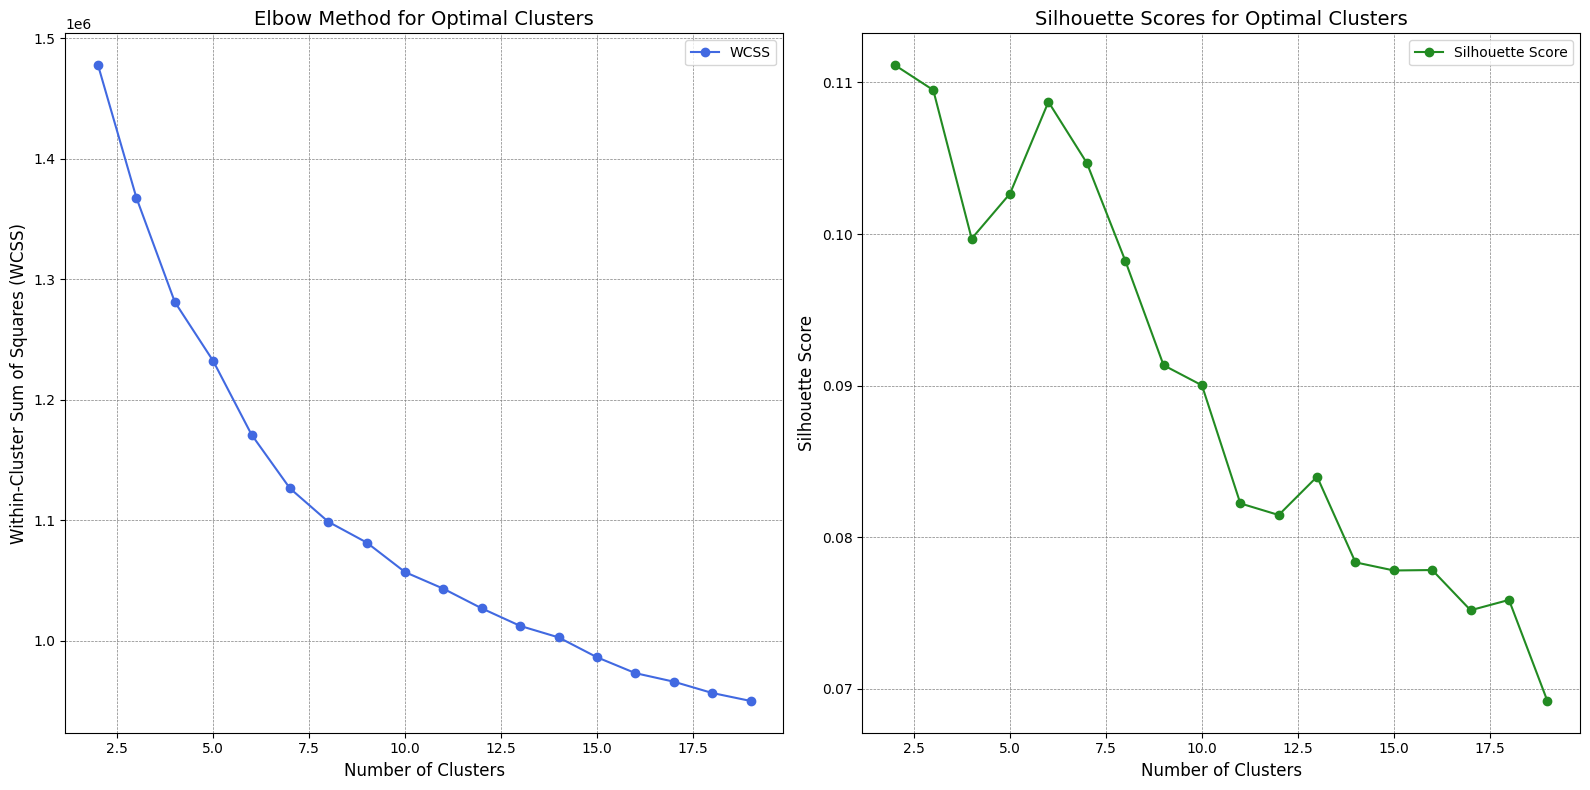

In [27]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
cluster_range = range(2, 20)

wcss = []
silhouette_scores = []
for n_clusters in tqdm(cluster_range, desc="Clustering", total=len(cluster_range)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(x)
    
    # Calculate WCSS
    wcss.append(kmeans.inertia_)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(x, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(16, 8))

# Subplot for WCSS
plt.subplot(1, 2, 1)
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='royalblue', label='WCSS')
plt.title('Elbow Method for Optimal Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.legend()

# Subplot for Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='forestgreen', label='Silhouette Score')
plt.title('Silhouette Scores for Optimal Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.legend()

# Adjust layout to prevent overlapping elements
plt.tight_layout()
plt.show()

In [31]:
kmeans = KMeans(n_clusters = 6 , random_state=1)
kmeans.fit(x)

KMeans(n_clusters=6, random_state=1)

Cluster 0:


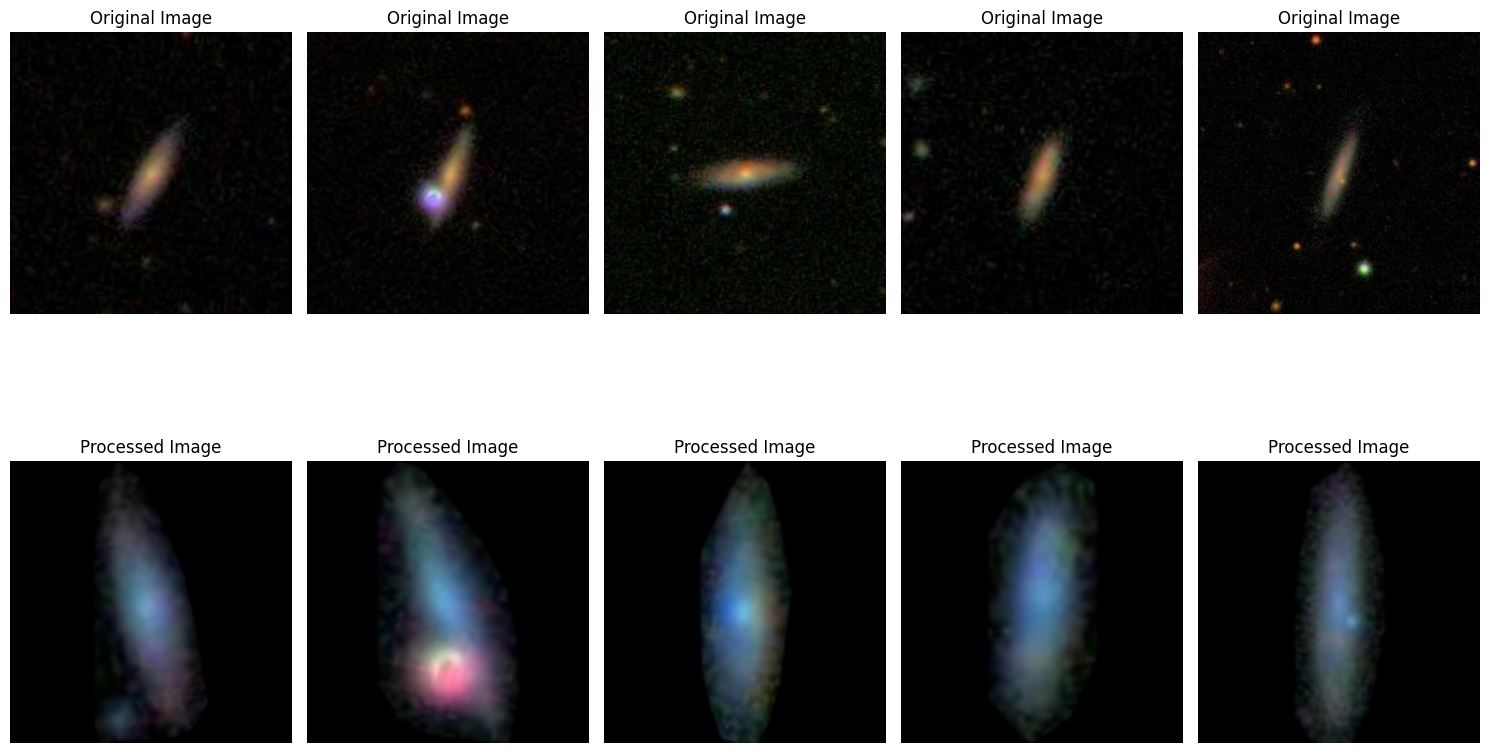

Cluster 1:


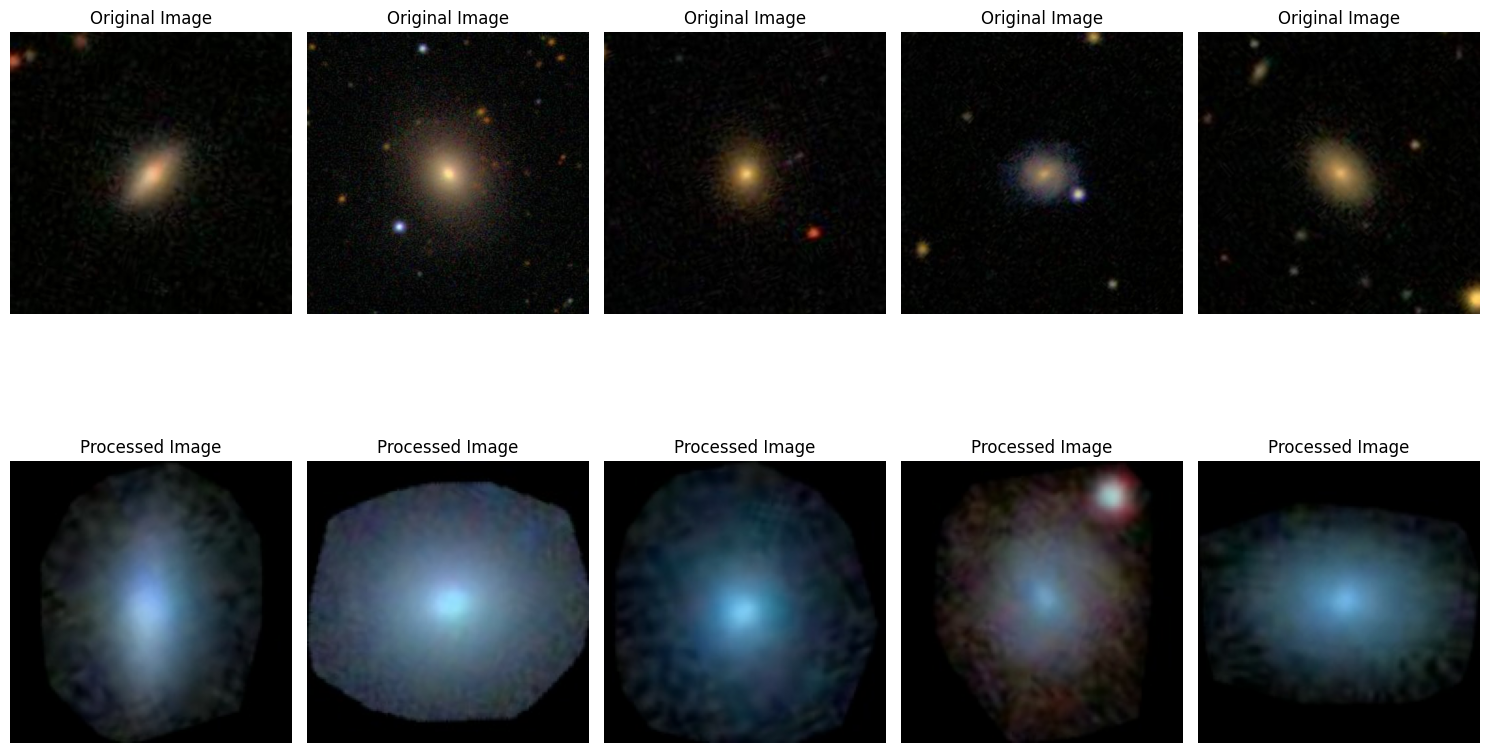

Cluster 2:


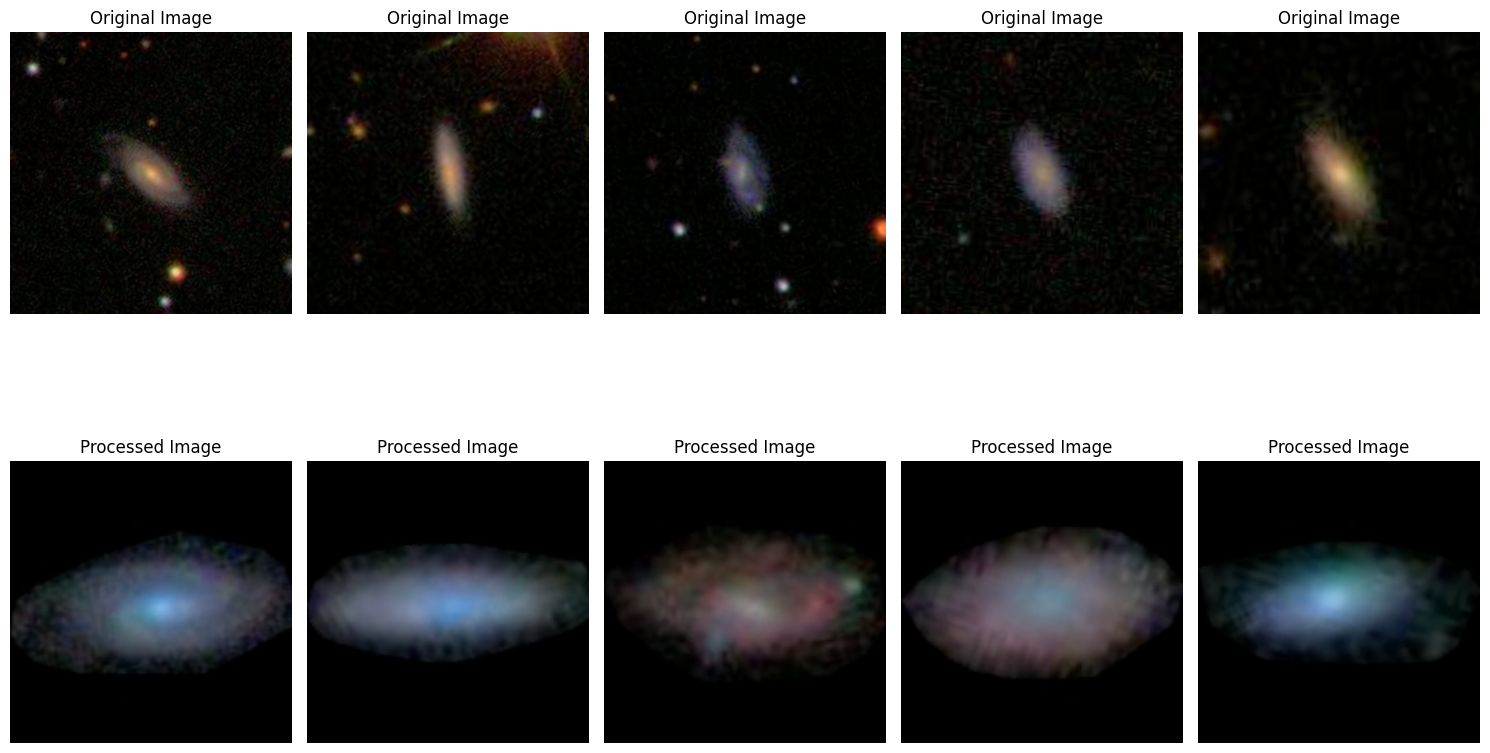

Cluster 3:


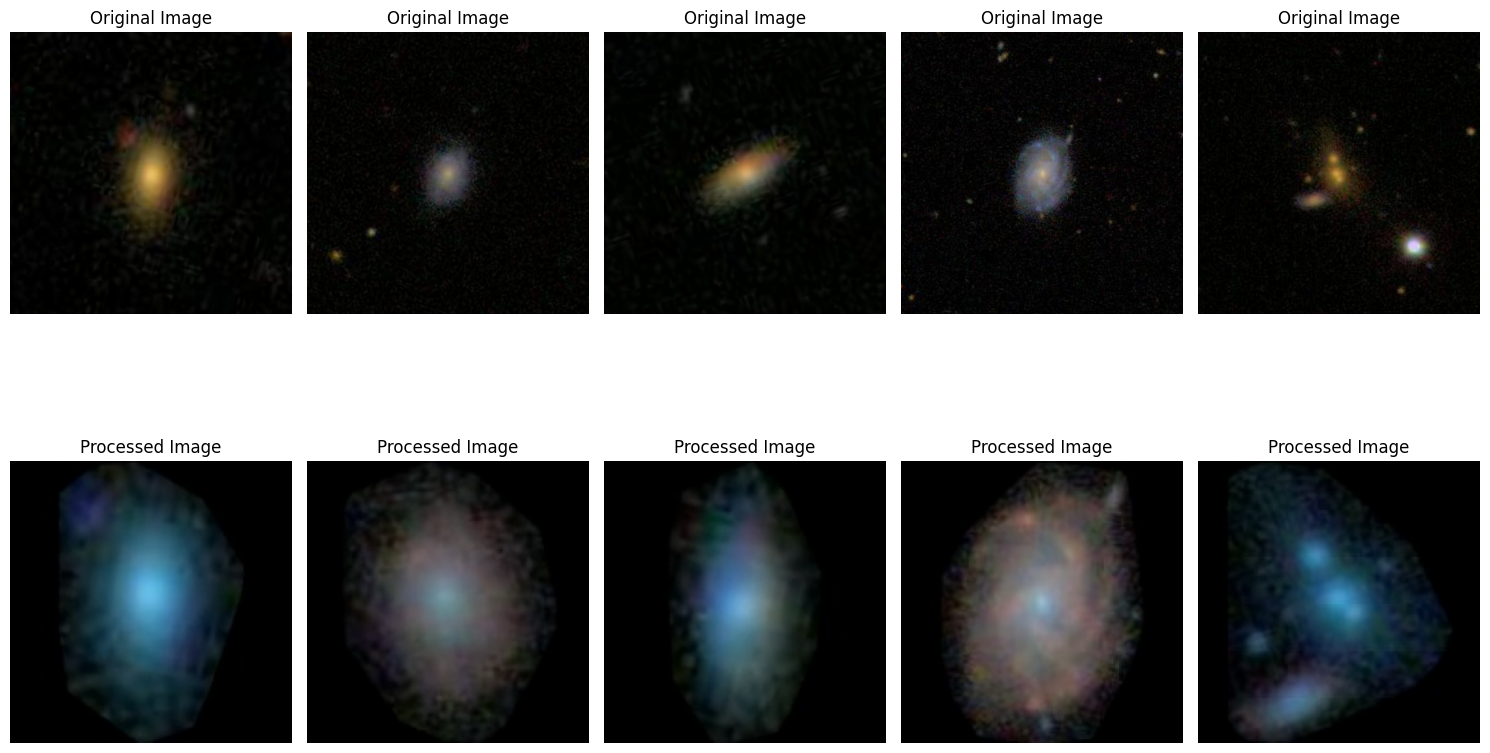

Cluster 4:


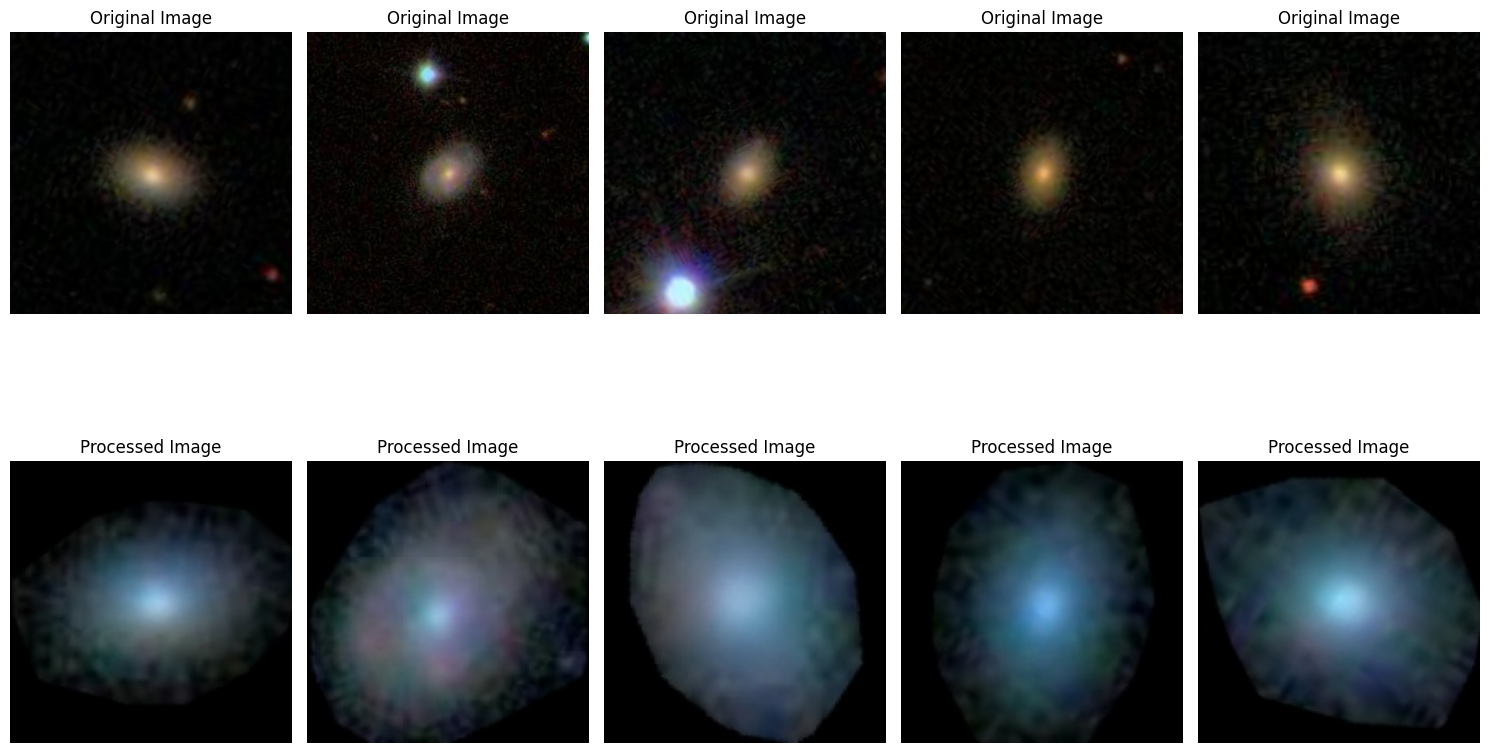

Cluster 5:


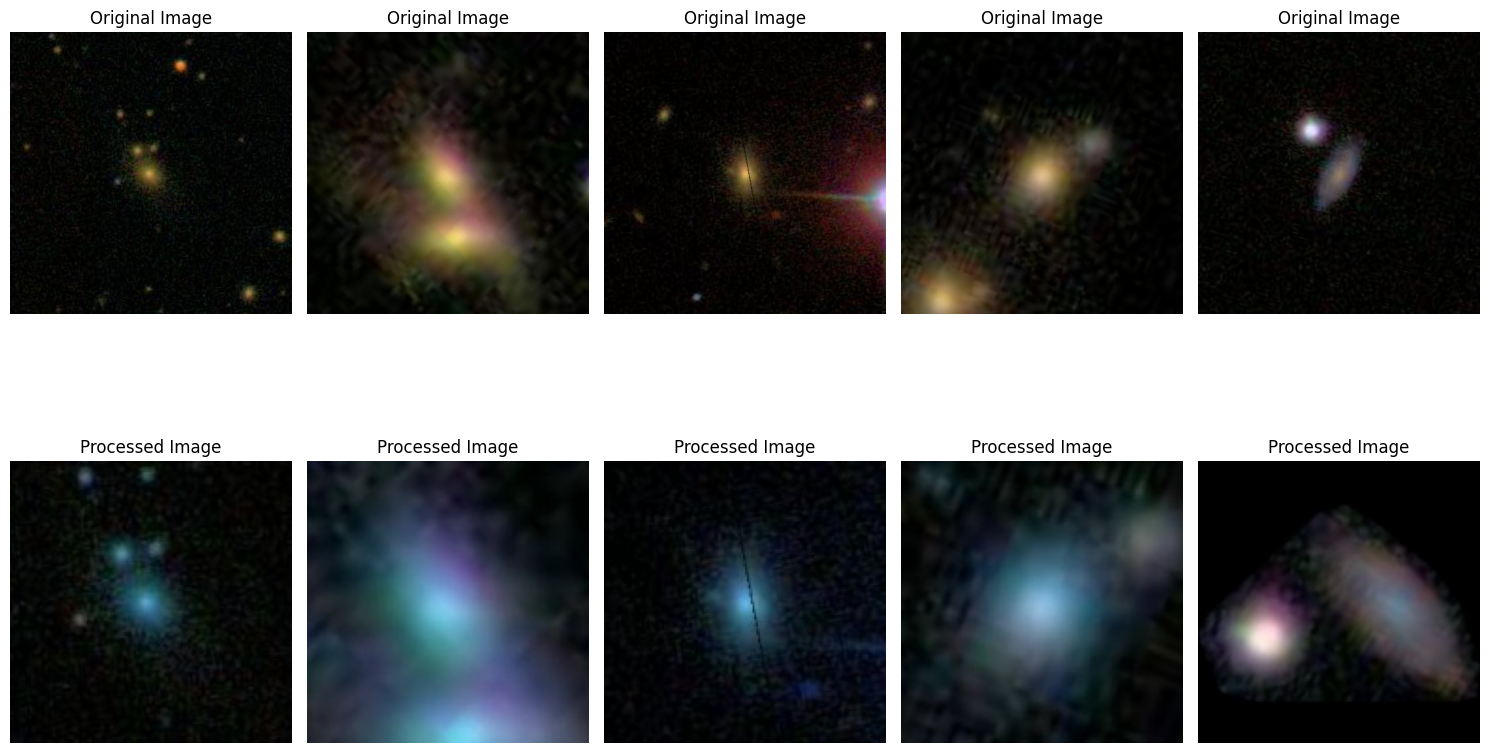

In [32]:
cluster_filenames = {}
for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in cluster_filenames:
        cluster_filenames[cluster] = []
    cluster_filenames[cluster].append(file)

# Function to display images in a cluster
def view_cluster(cluster, num_images=5):
    files = np.random.choice(cluster_filenames[cluster], size=min(num_images, len(cluster_filenames[cluster])), replace=False)
    plt.figure(figsize=(15, 10))
    for i, file in enumerate(files):
        original_file_path = os.path.join('..', 'data', 'galaxy_zoo', file)
        processed_file_path = os.path.join('..', 'data', 'processed', file)
        
        # Load original image
        original_img = load_img(original_file_path)
        
        # Load processed image
        processed_img = load_img(processed_file_path)
        
        # Plot original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_img)
        plt.title('Original Image')
        plt.axis('off')
        
        # Plot processed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(processed_img)
        plt.title('Processed Image')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()



# Visualize a random subset of images from each cluster
num_clusters_to_display = min(len(cluster_filenames), 10)  
for i in range(num_clusters_to_display):
    print(f"Cluster {i}:")
    view_cluster(i)
